In [1]:
import matplotlib.pyplot as plt
import sys
import os

sys.path.append('/home/davcic/CP_Testing')

args = 8
os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
print(f'Selected GPU {args}')

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel

Selected GPU 8


In [2]:
%load_ext autoreload
%autoreload 2

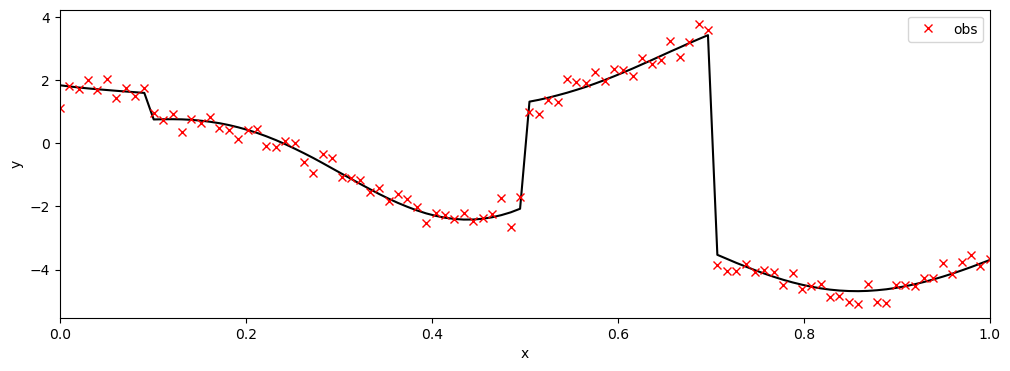

In [3]:
from New_kernel_1 import Discontinuous_multiple

key = jrnd.PRNGKey(12345)

lengthscale_ = 0.2
output_scale_ = 5.0
obs_noise_ = 0.3
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]

x0 = jnp.array([10, 50, 70])/n
base_kernel = jk.RBF()
kernel = Discontinuous_multiple(base_kernel)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        CP = x0),
                            x=x, y=x) + 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    CP=x0,
                    obs_noise=obs_noise_)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend();

In [17]:
num_CP = 3
priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp()),
                          variance=dx.Transformed(dx.Normal(loc=0.,
                                                            scale=1.),
                                                  tfb.Exp()),
                          CP=dx.Uniform(low=jnp.zeros(num_CP),
                                        high=jnp.ones(num_CP))
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp()))
                                                       )

gp_marginal = FullMarginalGPModel(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()
gp_latent = FullLatentGPModel(x, y, cov_fn=kernel, priors=priors)  # Defaults to likelihood=Gaussian()

num_particles = 1_000
num_mcmc_steps = 100

In [14]:
mgp_particles = jnp.load("mgp_particles.npy", allow_pickle = True)[0]
lgp_particles = jnp.load("lgp_particles.npy", allow_pickle = True)[0]

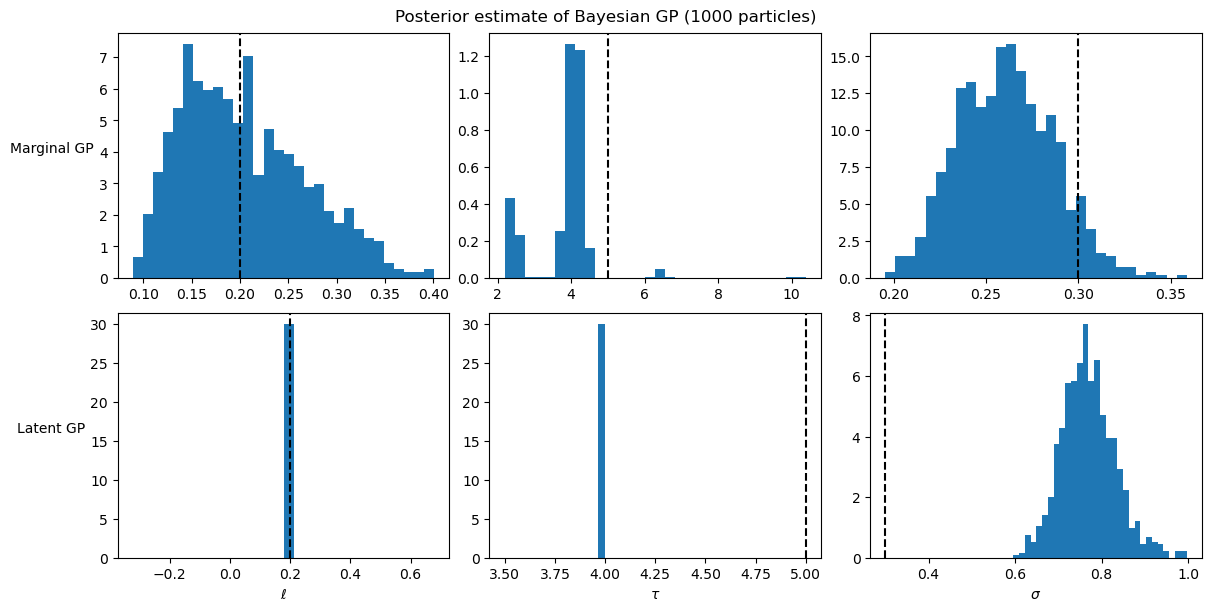

In [15]:
symbols = dict(lengthscale='\ell',
               obs_noise='\sigma',
               variance=r'\tau')

trainables = list()
for component, val in priors.items():
    trainables.extend(list(val.keys()))
trainables.remove('CP')
# trainables.remove('loss')



num_params = len(trainables)
show_samples = jnp.array([int(i) for i in num_particles*jnp.linspace(0, 1, num=500)])



_, axes = plt.subplots(nrows=2, ncols=num_params, constrained_layout=True,
                      figsize=(12, 6))

for m, particles in enumerate([mgp_particles, lgp_particles]):
    tr = dict(lengthscale=particles['kernel']['lengthscale'],
            variance=particles['kernel']['variance'],
            obs_noise=particles['likelihood']['obs_noise']
            )
    for j, var in enumerate(trainables):
        ax = axes[m, j]
        pd = tr[var]
        # There are some outliers that skew the axis
        # pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
        # pd_filtered = jnp.extract(pd>pd_l, pd)
        # pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
        ax.hist(pd, bins=30, density=True, color='tab:blue')
        if var in symbols and m==1:
            ax.set_xlabel(r'${:s}$'.format(symbols[var]))

plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('Marginal GP', rotation=0, ha='right')
axes[1, 0].set_ylabel('Latent GP', rotation=0, ha='right')

if len(ground_truth):
    for j, var in enumerate(trainables):
      if not(isinstance(ground_truth[var], float)):
        pass
        #[axes[0, j].axvline(x=_x, ls='--', c='k') for _x in ground_truth[var]]
        #[axes[1, j].axvline(x=_x, ls='--', c='k') for _x in ground_truth[var]]
      else:
        axes[0, j].axvline(x=ground_truth[var], ls='--', c='k');
        axes[1, j].axvline(x=ground_truth[var], ls='--', c='k');

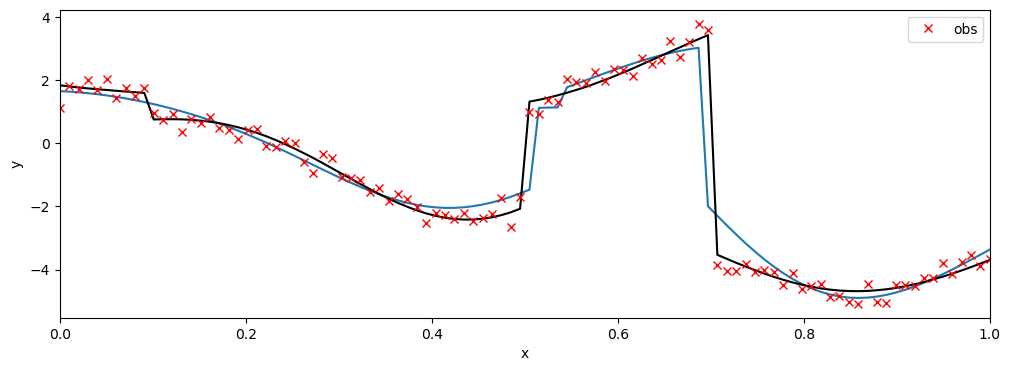

In [26]:
plt.figure(figsize=(12, 4))

plt.plot(x, jnp.mean(lgp_particles['f'], axis = 0))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend()
plt.show()

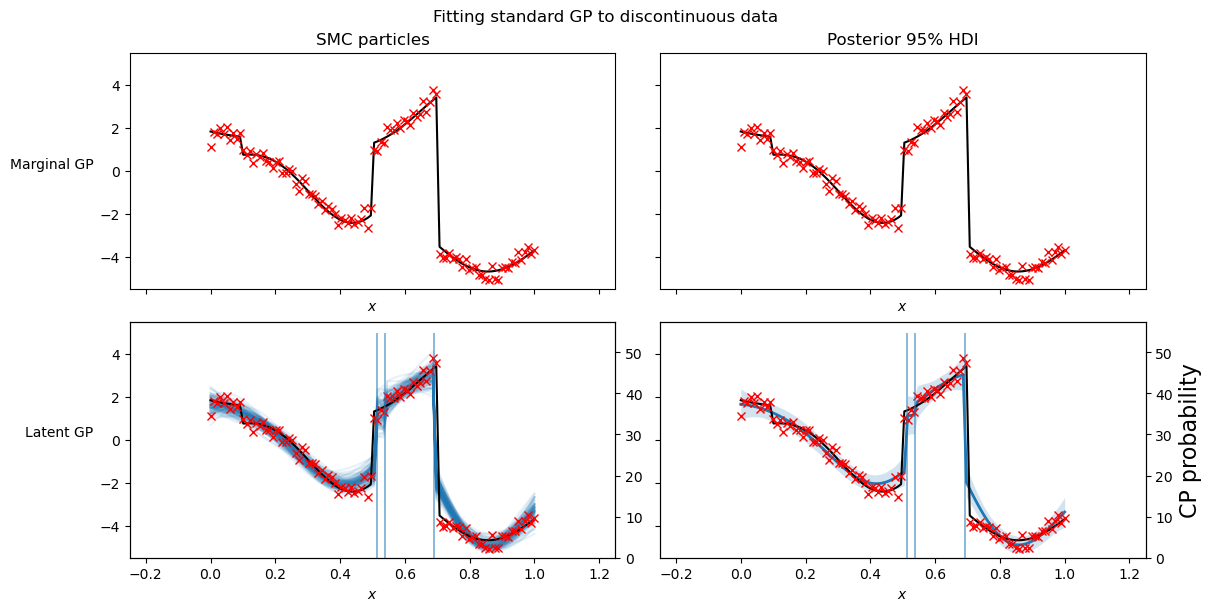

CPU times: user 3.31 s, sys: 898 ms, total: 4.21 s
Wall time: 2.91 s


In [31]:
%%time

x_pred = jnp.linspace(0, 1, num=100)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), sharex=True,
                            sharey=True, constrained_layout=True)

# for j, (gp, particles) in enumerate([[gp_marginal, mgp_particles], [gp_latent, lgp_particles]]):
key, key_pred = jrnd.split(key)
# f_pred = gp.predict_f(key_pred, x_pred)
f_pred = lgp_particles['f']
# print(f_pred)
pd = lgp_particles['kernel']['CP'].flatten()
# There are some outliers that skew the axis
# pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
# pd_filtered = jnp.extract(pd>pd_l, pd)
# pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
# print(pd_filtered.shape)

ax = axes[1, 0]
for i in jnp.arange(0, num_particles, step=10):
    ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

ax2 = ax.twinx()
ax2.hist(pd, bins=30, density=True, color='tab:blue', alpha=0.5)

ax = axes[1, 1]
f_mean = jnp.mean(f_pred, axis=0)
f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)

ax2 = ax.twinx()
ax2.hist(pd, bins=30, density=True, color='tab:blue', alpha=0.5)
ax2.set_ylabel('CP probability', fontsize=16)



for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, 1.25])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$')

axes[0, 0].set_title('SMC particles')
axes[0, 1].set_title('Posterior 95% HDI')

axes[0, 0].set_ylabel('Marginal GP', rotation=0, ha='right')
axes[1, 0].set_ylabel('Latent GP', rotation=0, ha='right')

fig.suptitle('Fitting standard GP to discontinuous data')
plt.show()